# Detectron2のセットアップ

In [1]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances

# データセット登録

硬貨の画像データセットを用意しました．各画像には1~4枚程度の硬貨（1円玉，5円玉，10円玉，100円玉の４種類，重複あり）が含まれています．`coco-1612779490.2197058.json`には各画像のAnnotation（硬貨の位置と種類）がCOCOフォーマットで入っています．ただし`IMG_4693.jpg`，`IMG_4694.jpg`，`IMG_4695.jpg`にはAnnotationはありません．テスト用に使います．

データセットを登録します．データセットをCOCOフォーマットで作っているので`register_coco_instances`で登録できます．

In [2]:
register_coco_instances("coins", {}, "./coins/coco-1612779490.2197058.json", "./coins")

データセットが正しく登録できているか確認します．

WARNING [07/02 01:17:06 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/02 01:17:06 d2.data.datasets.coco]: Loaded 32 images in COCO format from ./coins/coco-1612779490.2197058.json


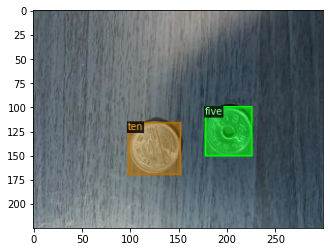

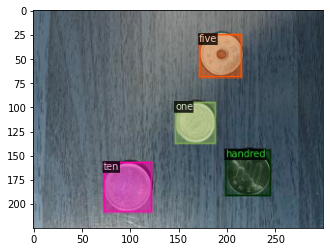

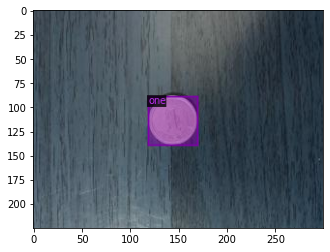

In [3]:
coins_metadata = MetadataCatalog.get("coins")
dataset_dicts = DatasetCatalog.get("coins")

for d in random.sample(dataset_dicts, 3):
  img = cv2.imread(d["file_name"])
  visualizer = Visualizer(img[:, :, ::-1], metadata=coins_metadata, scale=1.0)
  vis = visualizer.draw_dataset_dict(d)
  plt.imshow(vis.get_image()[:, :, ::-1])
  plt.show()

# 訓練

Model ZooにあるFaster RCNNを訓練します．今回は４種類の硬貨を検出するので，`cfg.MODEL.ROI_HEADS.NUM_CLASSES=4`にします．




In [4]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("coins",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0004
cfg.SOLVER.MAX_ITER = (
    500
)
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = (
    128
)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[07/02 01:17:11 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

WARNING [07/02 01:17:11 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[07/02 01:17:11 d2.data.datasets.coco]: Loaded 32 images in COCO format from ./coins/coco-1612779490.2197058.json
[07/02 01:17:11 d2.data.build]: Removed 0 images with no usable annotations. 32 images left.
[07/02 01:17:11 d2.data.build]: Distribution of instances among all 4 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|    one     | 27           |    five    | 13           |    ten     | 23           |
|  handred   | 20           |            |              |            |              |
|   total    | 83           |            |              |            |              |
[07/02 01:17:11 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (5, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (5,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (16, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (16,) in the model! You might want to double check if this is expected.


[07/02 01:17:11 d2.engine.train_loop]: Starting training from iteration 0
[07/02 01:17:19 d2.utils.events]:  eta: 0:02:48  iter: 19  total_loss: 2.604  loss_cls: 1.732  loss_box_reg: 0.8783  loss_rpn_cls: 0.002167  loss_rpn_loc: 0.004711  time: 0.3583  data_time: 0.0091  lr: 7.9924e-06  max_mem: 2310M
[07/02 01:17:26 d2.utils.events]:  eta: 0:02:41  iter: 39  total_loss: 2.344  loss_cls: 1.502  loss_box_reg: 0.7974  loss_rpn_cls: 0.002467  loss_rpn_loc: 0.004353  time: 0.3565  data_time: 0.0038  lr: 1.5984e-05  max_mem: 2310M
[07/02 01:17:33 d2.utils.events]:  eta: 0:02:34  iter: 59  total_loss: 2.006  loss_cls: 1.125  loss_box_reg: 0.8991  loss_rpn_cls: 0.001348  loss_rpn_loc: 0.003982  time: 0.3535  data_time: 0.0039  lr: 2.3976e-05  max_mem: 2310M
[07/02 01:17:40 d2.utils.events]:  eta: 0:02:27  iter: 79  total_loss: 1.662  loss_cls: 0.7707  loss_box_reg: 0.866  loss_rpn_cls: 0.001959  loss_rpn_loc: 0.003383  time: 0.3552  data_time: 0.0041  lr: 3.1968e-05  max_mem: 2310M
[07/02 01:

訓練したモデルを読み込みます．

In [5]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6
predictor = DefaultPredictor(cfg)

# テスト

訓練に使っていない画像で硬貨を検出してみます．

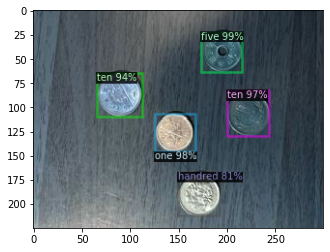

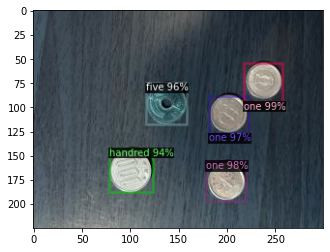

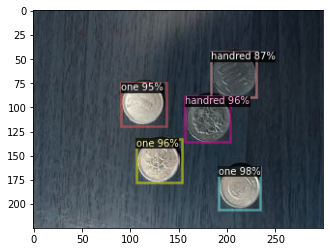

In [6]:
for num in [4693, 4694, 4695]:    
    im = cv2.imread(f"./coins/IMG_{num}.jpg")
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=coins_metadata, 
                   scale=1.0
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(v.get_image()[:, :, ::-1])
    plt.show()